In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
plt.close('all')

def create_input_PSD(freq_range):
    psd = np.zeros_like(freq_range)
    bump_location = np.where(np.abs(freq_range-injectFreq)<injectWidth)
    psd[bump_location] = injectPow  # Add signal
    return psd

def RF_filter(freq_range):
    filter_response = -100 * np.ones_like(freq_range)  # Initialize with high attenuation
    within_band = (freq_range >= rfStart) & (freq_range <= rfStop)
    filter_response[within_band] = 0  # 0 dB loss within the band
    return filter_response

def mixer(freq_range, LO):
    difference = LO - freq_range  # Difference frequencies
    low_side = np.where(difference >= 0, difference, np.nan)  # Take only the positive values, make others NaN
    high_side = np.where(difference < 0, -difference, np.nan)  # Take negative values, make them positive, make others NaN
    return low_side, high_side

def IF_filter(freq_range):
    filter_response = -100 * np.ones_like(freq_range)  # Initialize with high attenuation
    within_band = (freq_range >= ifStart) & (freq_range <= ifStop)  # Filtering the IF within 0 to 2 GHz range
    filter_response[within_band] = 0  # 0 dB loss within the band
    return filter_response

def combined_IF_power(freq_range, rf_filtered, LO):
    half_point = np.searchsorted(freq_range, LO)
    combined_if = np.zeros(half_point)  # IF will be half the size of the original signal
    for i, freq in enumerate(freq_range[:half_point]):
        low_power = 10 ** (rf_filtered[np.argmin(np.abs(freq_range - (LO - freq)))] / 10)
        high_power = 10 ** (rf_filtered[np.argmin(np.abs(freq_range - (LO + freq)))] / 10)
        combined_if[i] = 10 * np.log10(low_power + high_power)
    return freq_range[:half_point], combined_if


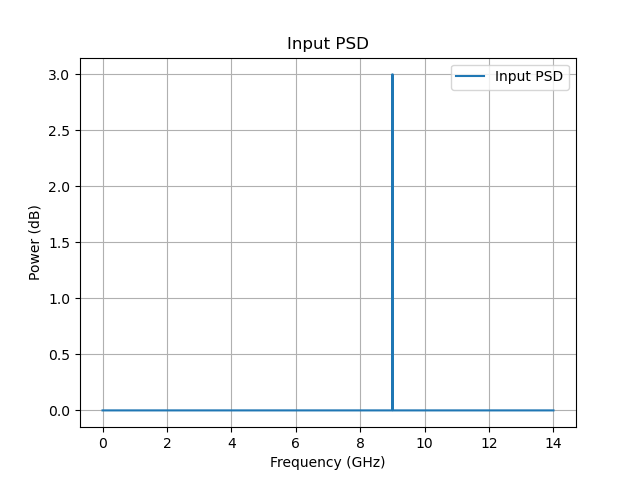

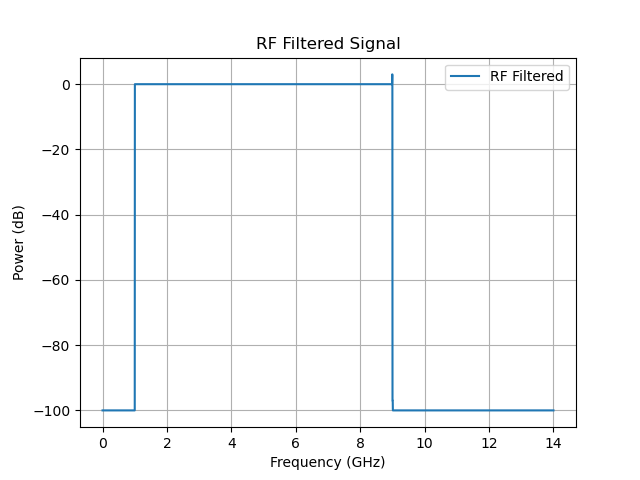

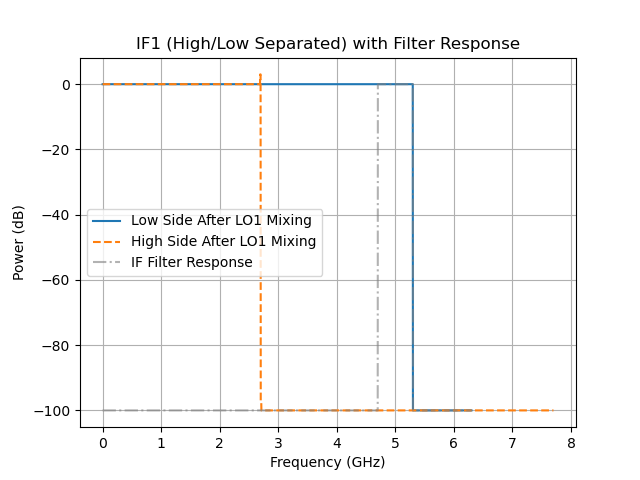

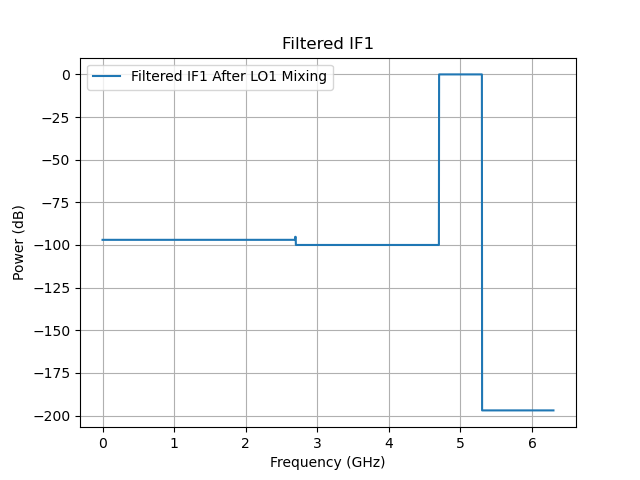

In [2]:


injectFreq  = 9 #GHz
injectWidth = 0.01 #GHz
injectPow   = 3 #dB

#rf filter parameters
rfStart     = 1 #GHz
rfStop      = 9 #GHz

#if filter parameters
ifStart     = 4.7 #GHz
ifStop      = 5.3 #GHz

LO          = 6.3 #GHz

freq_range = np.linspace(0, 14, 10000)

input_psd = create_input_PSD(freq_range)

# Plot the input PSD
plt.figure()
plt.plot(freq_range, input_psd, label='Input PSD')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dB)')
plt.title('Input PSD')
plt.legend()
plt.grid(True)

# Apply RF filter
rf_filtered = input_psd + RF_filter(freq_range)

# Plot the RF filtered signal
plt.figure()
plt.plot(freq_range, rf_filtered, label='RF Filtered')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dB)')
plt.title('RF Filtered Signal')
plt.legend()
plt.grid(True)

# Mix with LO1
low_side, high_side = mixer(freq_range, LO)
valid_low = ~np.isnan(low_side)
valid_high = ~np.isnan(high_side)

# Get combined IF power
if_freq, combined_if = combined_IF_power(freq_range, rf_filtered, LO)

# Apply IF filter
filtered_if = combined_if + IF_filter(if_freq)

plt.figure()
plt.plot(low_side[valid_low], rf_filtered[valid_low], label='Low Side After LO1 Mixing')
plt.plot(high_side[valid_high], rf_filtered[valid_high], '--', label='High Side After LO1 Mixing')
plt.plot(if_freq, IF_filter(if_freq), '-.', label='IF Filter Response', color='grey', alpha=0.6)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dB)')
plt.title('IF1 (High/Low Separated) with Filter Response')
plt.legend()
plt.grid(True)


# Plot the combined IF
plt.figure()
plt.plot(if_freq, filtered_if, label='Filtered IF1 After LO1 Mixing')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dB)')
plt.title('Filtered IF1')
plt.legend()
plt.grid(True)
